### Monopoly



Team members: working individually (Dariia Shevchuk 161200)

Selected board game: Monopoly (classic edition)

Short description:
Monopoly is a turn-based board game where players move their pawns around the board using dice, buy properties they land on, pay rent to other players, and manage money with the goal of becoming the last player not bankrupt.

List of in-game items I detect: 
- Board board with fixed square positions and fields.
- 2 pawns
- 2 standard 6-sided dice
- Community / change cards
- players` hands

Events I detect:
- hand is present or not
- move a pawn from one field to another
- roll dice


In [16]:
import os, sys, json, math
from dataclasses import asdict
import numpy as np
import cv2
import matplotlib.pyplot as plt


import detect_board as board
import detect_hand as hand
import detect_cards as cards
import detect_pawns as pawns
import detect_dice as dice

def bgr2rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def show(img_bgr, title="", figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(bgr2rgb(img_bgr))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [17]:
VIDEO_PATH = "data/easy/2_easy.mp4" 

def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return {"fps": fps, "n_frames": n, "w": w, "h": h}

def read_frame(video_path, frame_idx):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise ValueError(f"Failed reading frame {frame_idx} from {video_path}")
    return frame

info = get_video_info(VIDEO_PATH)
info


{'fps': 29.97002997002997, 'n_frames': 5659, 'w': 1902, 'h': 2188}

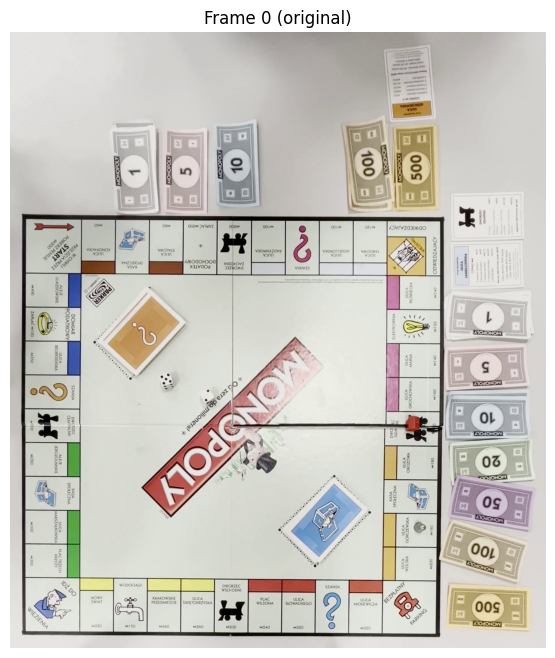

In [18]:
frame0 = read_frame(VIDEO_PATH, frame_idx=0)
show(frame0, "Frame 0 (original)")


### Board calibration: homography + canonical board coordinates

**Goal:** map each video frame to a fixed top-down board coordinate system (square `warp_size × warp_size`) so all later detections become geometry-stable.

**Method:**
- Detect the **board outer quadrilateral** in multiple frames using **Canny edges → dilation → contour search → polygon approximation** (keep the best 4-corner contour above an area threshold).
- Compute a median quad across frames to reduce noise, then estimate a perspective homography to warp the board into a canonical square.
- Detect the inner playing area box in warped space using **Sobel edge profiles** (strong vertical/horizontal gradient peaks) and take the median across frames for stability.


inner_box: (124, 126, 777, 777)
dice_roi: (124, 126, 777, 777)
fields: 40 meta: {'t_left': 124, 't_top': 126, 't_right': 123, 't_bottom': 123, 'cell_x': 72.55555555555556, 'cell_y': 72.33333333333333}


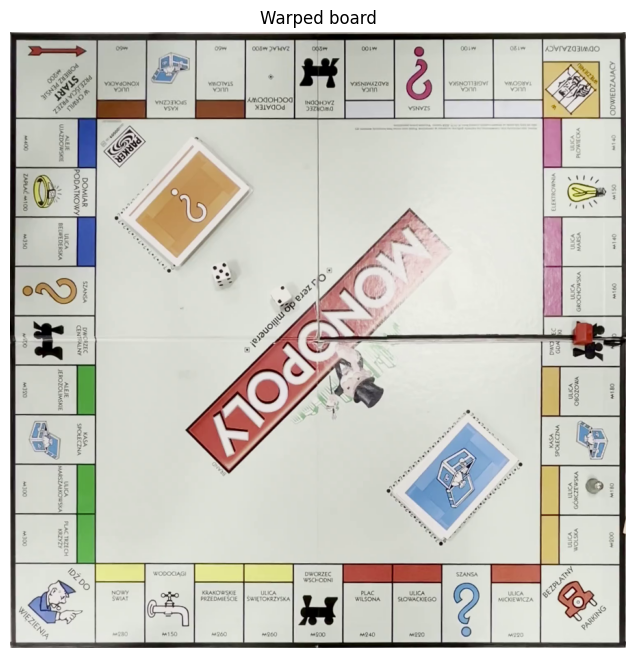

In [ ]:
VIDEO_PATH = "data/easy/2_easy.mp4"
WARP_SIZE = 900

cal_cfg = board.CalibCFG(
    video_path=VIDEO_PATH,
    warp_size=WARP_SIZE,

    blur_ksize=7,
    canny1=60,
    canny2=160,
    dilate_ksize=3,
    approx_eps_ratio=0.02,
    quad_area_ratio_min=0.15,
    max_contours_to_try=12,

    board_sample_frames=80,  
    inner_sample_frames=70,  

    band_ratio=0.30,
    smooth_ksize=51,
    min_margin_ratio=0.06,
)

H, quad_med = board.estimate_homography(VIDEO_PATH, cal_cfg)
inner_box = board.estimate_inner_box_median(VIDEO_PATH, H, cal_cfg)
fields, meta = board.build_monopoly_fields_robust(WARP_SIZE, inner_box)

outer_mask, inner_mask, ring_mask, dice_roi, dice_roi_mask = board.build_masks(WARP_SIZE, inner_box)

frame0 = read_frame(VIDEO_PATH, 0)
warped0 = board.warp_board(frame0, H, WARP_SIZE)

print("inner_box:", inner_box)
print("dice_roi:", dice_roi)
print("fields:", len(fields), "meta:", meta)
show(warped0, "Warped board")


In [19]:
import json
import numpy as np

def save_fields_coords(path, H, warp_size, inner_box, fields, dice_roi):
    def field_centers(fields):
        return [((x1+x2)/2.0, (y1+y2)/2.0) for (x1,y1,x2,y2) in fields]

    payload = {
        "warp_size": int(warp_size),
        "H": np.asarray(H, dtype=float).tolist(),
        "inner_box": [int(v) for v in inner_box],
        "dice_roi": [int(v) for v in dice_roi],
        "fields": []
    }
    centers = field_centers(fields)
    for i, (rect, (cx, cy)) in enumerate(zip(fields, centers)):
        x1,y1,x2,y2 = rect
        payload["fields"].append({
            "id": int(i),
            "rect": [int(x1), int(y1), int(x2), int(y2)],
            "center": [float(cx), float(cy)]
        })

    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

save_fields_coords("outputs/fields_coords.json", H, WARP_SIZE, inner_box, fields, dice_roi)
print("Saved outputs/fields_coords.json")


Saved outputs/fields_coords.json


In [20]:
from types import SimpleNamespace

calib = SimpleNamespace(
    H=H,
    warp_size=WARP_SIZE,
    inner_box=inner_box,
    dice_roi=dice_roi,
    fields=fields
)

print("calib ready:", calib.warp_size, calib.inner_box)


calib ready: 900 (124, 126, 777, 777)


### Board geometry: 40 fields + region masks

**Fields (board squares):**
- Build 40 rectangles by using the detected `inner_box` as a reference.
- Compute border thickness on each side and divide each edge into 9 equal segments to get consistent field rectangles around the ring.

**Masks:**
- `inner_mask`: the central rectangle (used for cards + dice detection).
- `ring_mask`: outer minus inner (used for pawn detection on the track).


In [8]:
def rect_to_xyxy(rect):
    r = rect
    if isinstance(r, np.ndarray):
        r = r.tolist()

    # ((x1,y1),(x2,y2))
    if isinstance(r, (list, tuple)) and len(r) == 2 and isinstance(r[0], (list, tuple)):
        (x1, y1), (x2, y2) = r
    # (x1,y1,x2,y2)
    elif isinstance(r, (list, tuple)) and len(r) == 4:
        x1, y1, x2, y2 = r
    else:
        raise TypeError(f"Unsupported rect format: {type(rect)} -> {rect}")

    x1,y1,x2,y2 = map(int, (x1,y1,x2,y2))
    return min(x1,x2), min(y1,y2), max(x1,x2), max(y1,y2)

def draw_rect(img_bgr, rect, color=(0,255,0), thickness=2, label=None):
    x1,y1,x2,y2 = rect_to_xyxy(rect)
    out = img_bgr.copy()
    cv2.rectangle(out, (x1,y1), (x2,y2), color, thickness)
    if label is not None:
        cv2.putText(out, str(label), (x1, max(0, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return out

def draw_fields(img_bgr, fields, step=1):
    out = img_bgr.copy()
    for i, r in enumerate(fields):
        if step > 1 and (i % step != 0):
            continue
        out = draw_rect(out, r, color=(0,200,255), thickness=2, label=i)
    return out

def draw_quads(img_bgr, quads, color=(255,0,0), thickness=2):
    out = img_bgr.copy()
    for q in quads:
        pts = np.array(q, dtype=np.int32).reshape(-1,2)
        cv2.polylines(out, [pts], True, color, thickness)
    return out

def point_in_rect(pt_xy, rect):
    x, y = pt_xy
    x1,y1,x2,y2 = rect_to_xyxy(rect)
    return (x1 <= x <= x2) and (y1 <= y <= y2)

def assign_field_id(center_xy, fields):
    for i, r in enumerate(fields):
        if point_in_rect(center_xy, r):
            return i
    cx, cy = center_xy
    centers = []
    for r in fields:
        x1,y1,x2,y2 = rect_to_xyxy(r)
        centers.append(((x1+x2)/2, (y1+y2)/2))
    d2 = [(i, (cx-x)**2 + (cy-y)**2) for i,(x,y) in enumerate(centers)]
    return min(d2, key=lambda t: t[1])[0] if d2 else None


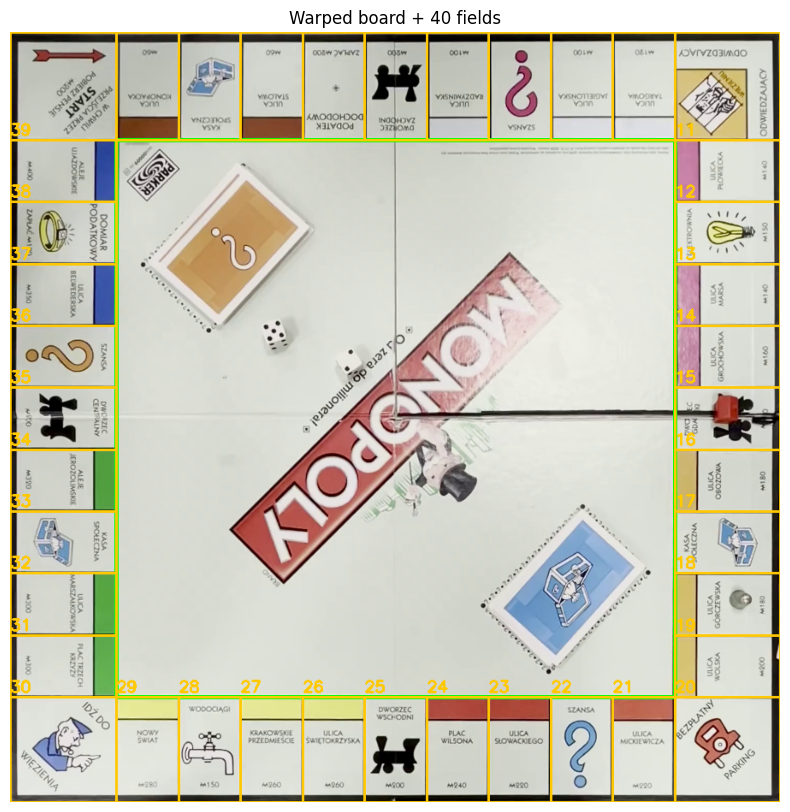

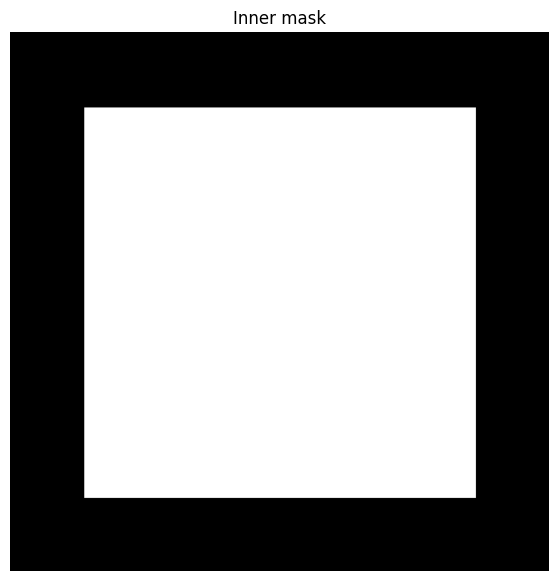

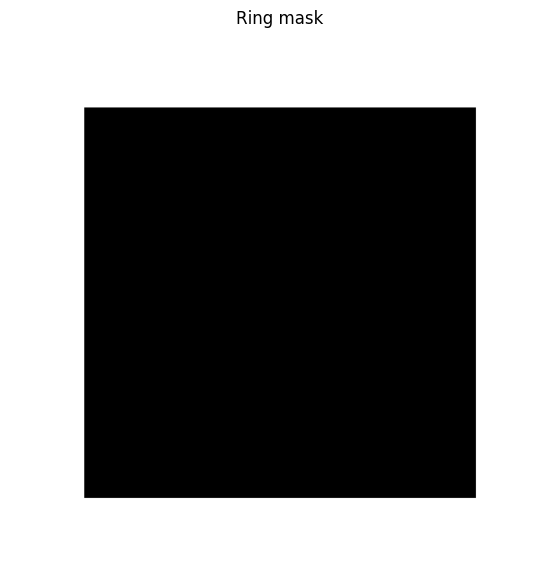

In [9]:
vis = warped0.copy()
vis = draw_rect(vis, calib.inner_box, color=(0,255,0), thickness=3)
vis = draw_fields(vis, calib.fields, step=1)
show(vis, "Warped board + 40 fields", figsize=(10,10))

show(cv2.cvtColor(inner_mask, cv2.COLOR_GRAY2BGR), "Inner mask", figsize=(7,7))
show(cv2.cvtColor(ring_mask, cv2.COLOR_GRAY2BGR), "Ring mask", figsize=(7,7))

### Hand detection (motion and skin)

Goal: detect time intervals when a hand is on the board to avoid interpreting occlusions as game events.

Nethod:
- Build a running grayscale **background model** using `accumulateWeighted`.
- For each frame compute:
  - **skin mask** in HSV (hand-color range),
  - **motion mask** via abs-diff vs background + threshold,
  - combine them with **AND** to isolate moving skin-like regions.
- Decide `hand_present` if the hand-mask pixel ratio in ROI exceeds a threshold.
- Convert frame-wise booleans into **time intervals** and merge close intervals for stability.


In [10]:
params = hand.Params() 

# set ROI but its not needed here
roi = None  

hand_result = hand.process_video(VIDEO_PATH, roi=roi, p=params, debug=False)

os.makedirs("outputs", exist_ok=True)
with open("outputs/hand_periods.json", "w") as f:
    json.dump(hand_result, f, indent=2)

hand_result.keys(), hand_result["hand_present_intervals"][:5]


(dict_keys(['video', 'fps', 'total_seconds', 'roi', 'params', 'hand_present_intervals', 'no_hand_intervals']),
 [(0.8341666666666667, 20.7207),
  (23.690333333333335, 27.727700000000002),
  (28.2282, 32.06536666666667),
  (42.10873333333333, 43.143100000000004),
  (43.5435, 188.82196666666667)])

In [11]:
print("preview the file:")

with open("outputs/hand_periods.json","r") as f:
    txt = f.read()
print(txt[:1200] + ("\n... (truncated)" if len(txt) > 1200 else ""))


preview the file:
{
  "video": "data/easy/2_easy.mp4",
  "fps": 29.97002997002997,
  "total_seconds": 188.82196666666667,
  "roi": null,
  "params": {
    "resize_width": 960,
    "blur_ksize": 9,
    "bg_alpha": 0.03,
    "diff_thresh": 25,
    "motion_open_ksize": 5,
    "skin_open_ksize": 5,
    "min_hand_ratio": 0.006,
    "min_interval_s": 0.25,
    "merge_gap_s": 0.2,
    "warmup_frames": 30
  },
  "hand_present_intervals": [
    [
      0.8341666666666667,
      20.7207
    ],
    [
      23.690333333333335,
      27.727700000000002
    ],
    [
      28.2282,
      32.06536666666667
    ],
    [
      42.10873333333333,
      43.143100000000004
    ],
    [
      43.5435,
      188.82196666666667
    ]
  ],
  "no_hand_intervals": [
    [
      0.0,
      0.8341666666666667
    ],
    [
      20.7207,
      23.690333333333335
    ],
    [
      27.727700000000002,
      28.2282
    ],
    [
      32.06536666666667,
      42.10873333333333
    ],
    [
      43.143100000000004,
 

In [12]:
def warp_any(frame_bgr, H, warp_size):
    if hasattr(board, "warp_frame"):
        return board.warp_frame(frame_bgr, H, warp_size)
    return board.warp_board(frame_bgr, H, warp_size)


In [ ]:
def is_hand_present_at_t(hand_json, t):
    for a,b in hand_json["hand_present_intervals"]:
        if a <= t <= b:
            return True
    return False

def majority_vote(seq):
    from collections import Counter
    c = Counter(tuple(x) for x in seq if x is not None)
    return list(c.most_common(1)[0][0]) if c else None


### Card detection in the inner field

Cards are detected in the inner field using edge detection and contour analysis.  
Contours approximated by convex quadrilaterals with card-like aspect ratios are selected.

Optional HSV filtering is applied to suppress false detections caused by background textures.
Detected card positions are reported in warped board coordinates.


### Pawn detection using background subtraction

Pawn detection is performed in the outer ring of the board by subtracting a clean background image from the warped frame.

A robust threshold based on median and MAD statistics separates foreground objects.  
Contour filtering based on area, shape, solidity, and aspect ratio is used to identify pawns.

A clean background is estimated automatically from the video using a median-based method over low-motion frames.


### Pawn detection using background subtraction

Pawn detection is performed in the outer ring of the board by subtracting a clean background image from the warped frame.

A robust threshold based on median and MAD statistics separates foreground objects.  
Contour filtering based on area, shape, solidity, and aspect ratio is used to identify pawns.

A clean background is estimated automatically from the video using a median-based method over low-motion frames.


### Event detection from temporal changes

Gameplay events are detected by comparing states across frames:
- hand appearance/disappearance from hand intervals
- dice roll completion from stable dice values
- pawn movement from changes in field assignments


In [ ]:
def run_full_video(
    video_path,
    calib,
    hand_json,
    out_video_path="outputs/annotated.mp4",
    out_events_path="outputs/events.json",
    out_jsonl_path="outputs/detections.jsonl",
    max_frames=None,
    stable_n=8
):
    os.makedirs("outputs", exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_video_path, fourcc, fps, (calib.warp_size, calib.warp_size))

    bg_cfg = pawns.PawnBGCFG(mode="estimated", video_path=VIDEO_PATH)
    bg_provider = pawns.PawnBackgroundProvider(bg_cfg, calib.H, calib.warp_size, roi_mask=ring_mask)
    pawn_cfg = pawns.PawnCFG()

    events = []
    last_hand = False
    dice_hist = []
    last_dice_stable = None
    last_pawn_fields = None

    f = open(out_jsonl_path, "w")
    idx = 0

    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if max_frames is not None and idx >= max_frames:
            break

        t = idx / fps
        warped = warp_any(frame, calib.H, calib.warp_size)

        # detections
        card_det = cards.detect_cards_in_inner_field(warped, calib.inner_box)
        dice_det = dice.detect_dice_in_inner_field(warped, calib.inner_box)
        pawn_list, _, _ = pawns.detect_pawns_from_frame(
            frame_bgr=frame,
            H=calib.H,
            warp_size=calib.warp_size,
            ring_mask=ring_mask,
            bg=bg_provider,
            prev_centers=None,
            cfg=pawn_cfg,
            return_debug_images=False
        )

        pawn_fields = []
        for p in pawn_list:
            cx, cy = p["center"]
            pawn_fields.append(assign_field_id((cx, cy), calib.fields))
        pawn_fields = pawn_fields[:2]

        hand_now = is_hand_present_at_t(hand_json, t)

        # events
        if (not last_hand) and hand_now:
            events.append({"t": t, "type": "HAND_APPEARS"})
        if last_hand and (not hand_now):
            events.append({"t": t, "type": "HAND_DISAPPEARS"})

        dice_vals = dice_det.dice_values if dice_det.dice_values else None
        dice_hist.append(dice_vals)
        if len(dice_hist) > stable_n:
            dice_hist.pop(0)
        dice_stable = majority_vote(dice_hist) if len(dice_hist) == stable_n else None
        if dice_stable is not None and dice_stable != last_dice_stable:
            events.append({"t": t, "type": "DICE_STABLE", "dice": dice_stable})
            last_dice_stable = dice_stable

        if last_pawn_fields is not None and (not hand_now) and (pawn_fields != last_pawn_fields):
            events.append({"t": t, "type": "PAWN_MOVED", "from": last_pawn_fields, "to": pawn_fields})
        last_pawn_fields = pawn_fields
        last_hand = hand_now

        # detections
        rec = {
            "frame": idx, "t": t, "hand": bool(hand_now),
            "dice": dice_vals, "pawn_fields": pawn_fields,
            "n_cards": len(getattr(card_det, "quads_warped", []) or []),
        }
        f.write(json.dumps(rec) + "\n")

        # annotate
        vis = warped.copy()
        vis = draw_rect(vis, calib.inner_box, color=(0,255,0), thickness=2)
        if getattr(card_det, "quads_warped", None):
            vis = draw_quads(vis, card_det.quads_warped, color=(255,0,0), thickness=3)
        if getattr(dice_det, "boxes_warped", None):
            for i, b in enumerate(dice_det.boxes_warped):
                label = str(dice_det.dice_values[i]) if dice_det.dice_values else "die"
                vis = draw_rect(vis, b, color=(0,255,255), thickness=3, label=label)
        for i,p in enumerate(pawn_list):
            cx, cy = p["center"]
            fid = assign_field_id((cx, cy), calib.fields)
            vis = draw_rect(vis, p["bbox"], color=(255,0,255), thickness=3, label=f"pawn{i}@{fid}")

        cv2.putText(vis, f"t={t:.2f}s hand={int(hand_now)}", (10, 28),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        if events:
            cv2.putText(vis, f"{events[-1]['type']}", (10, 58),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

        writer.write(vis)
        idx += 1

    f.close()
    cap.release()
    writer.release()

    with open(out_events_path, "w") as ff:
        json.dump(events, ff, indent=2)

    return {"out_video": out_video_path, "out_events": out_events_path, "out_jsonl": out_jsonl_path, "n_events": len(events)}


In [15]:
result = run_full_video(
    VIDEO_PATH,
    calib=calib,
    hand_json=hand_result,  
    out_video_path="outputs/annotated.mp4",
    out_events_path="outputs/events.json",
    out_jsonl_path="outputs/detections.jsonl",
    max_frames=600,   ### NULL 
    stable_n=8
)
result


{'out_video': 'outputs/annotated.mp4',
 'out_events': 'outputs/events.json',
 'out_jsonl': 'outputs/detections.jsonl',
 'n_events': 47}